# 0. Initial imports and loading data

In [10]:
import math 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from meteostat import Point, Daily

import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns



pd.set_option('display.max_columns', None)

In [2]:
project_dir = "."

In [3]:
df_311 = pd.read_csv(f"{project_dir}/data/311_data.csv", index_col=0)
df_weather = pd.read_csv(f"{project_dir}/data/weather_data.csv", index_col=0)

In [12]:
df_311.created_date = pd.to_datetime(df_311.created_date)

# 1. EDA

In [8]:
df_311.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,agency,latitude,longitude,borough,location_type,incident_zip,day,month,day_of_week,hour
0,56417527,2023-01-01 00:00:09,2023-01-01 00:36:06,Illegal Fireworks,n a,NYPD,40.640915,-73.973642,BROOKLYN,Street/Sidewalk,11218.0,2023-01-01,1,6,0
1,56416252,2023-01-01 00:00:42,2023-01-01 17:34:15,Noise - Residential,loud music party,NYPD,40.853848,-73.917709,BRONX,Residential Building/House,10453.0,2023-01-01,1,6,0
2,56418795,2023-01-01 00:00:45,2023-01-01 01:24:10,Illegal Parking,posted parking sign violation,NYPD,40.754875,-74.000747,MANHATTAN,Street/Sidewalk,10001.0,2023-01-01,1,6,0
3,56418136,2023-01-01 00:00:46,2023-01-01 01:01:43,Noise - Residential,loud music party,NYPD,40.620665,-73.926040,BROOKLYN,Residential Building/House,11234.0,2023-01-01,1,6,0
4,56413896,2023-01-01 00:00:57,2023-01-04 15:09:28,Street Condition,blocked construction,DOT,40.849297,-73.910479,BRONX,Street,10453.0,2023-01-01,1,6,0


In [4]:
df_weather.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2023-01-01,10.9,5.3,12.0,0.4,0.0,NaN,9.9,NaN,1013.6,NaN
2023-01-02,11.4,9.0,13.0,0.5,0.0,NaN,7.2,NaN,1020.2,NaN
2023-01-03,11.1,8.0,14.0,9.6,0.0,NaN,8.5,NaN,1014.9,NaN
2023-01-04,14.4,9.0,19.0,9.9,0.0,NaN,8.8,NaN,1010.9,NaN
2023-01-05,8.6,7.0,10.0,0.4,0.0,NaN,8.5,NaN,1014.7,NaN


In [17]:
len(df_311['complaint_type'].unique())

208

In [6]:
top_complaints = df_311['complaint_type'].value_counts().head(20)

print("Top 20 Complaint Types by Volume:")
print(top_complaints)

Top 20 Complaint Types by Volume:
complaint_type
Illegal Parking            976325
Noise - Residential        676005
Heat/Hot Water             496025
Blocked Driveway           336007
Noise - Street/Sidewalk    307468
Unsanitary Condition       237573
Noise - Commercial         135759
Plumbing                   135158
Abandoned Vehicle          133738
Paint/Plaster              125805
Water System               117590
Dirty Condition            107770
Noise - Unspecified        106761
Noise - Vehicle             98677
Street Condition            98472
Door/Window                 91866
Derelict Vehicles           91689
Water Leak                  91385
Missed Collection           88827
Noise - Helicopter          87808
Name: count, dtype: int64


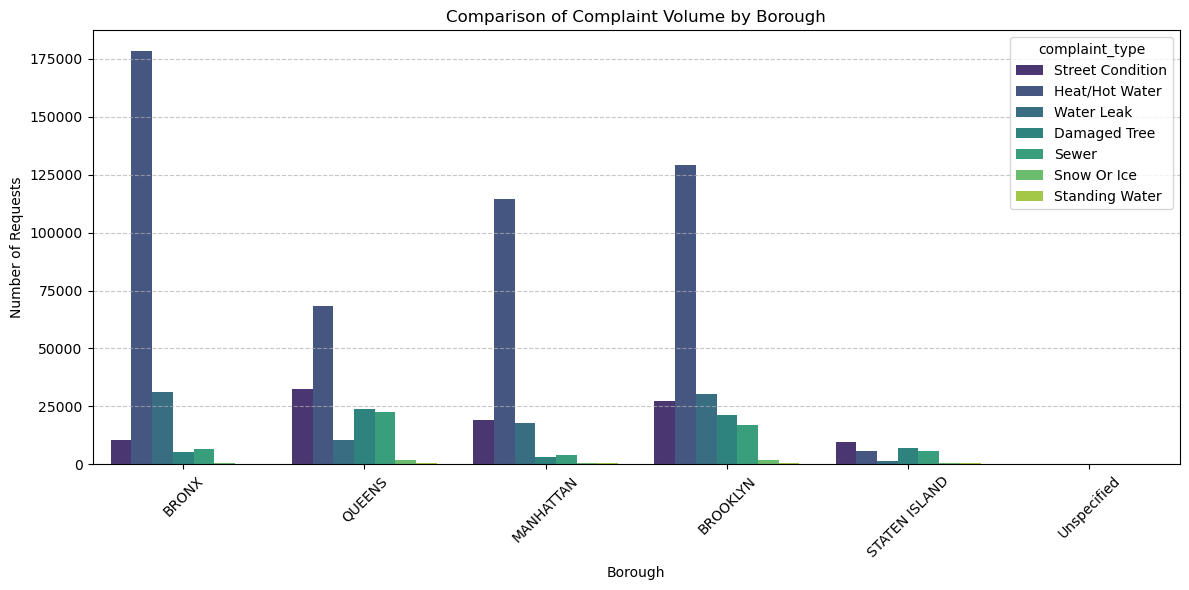

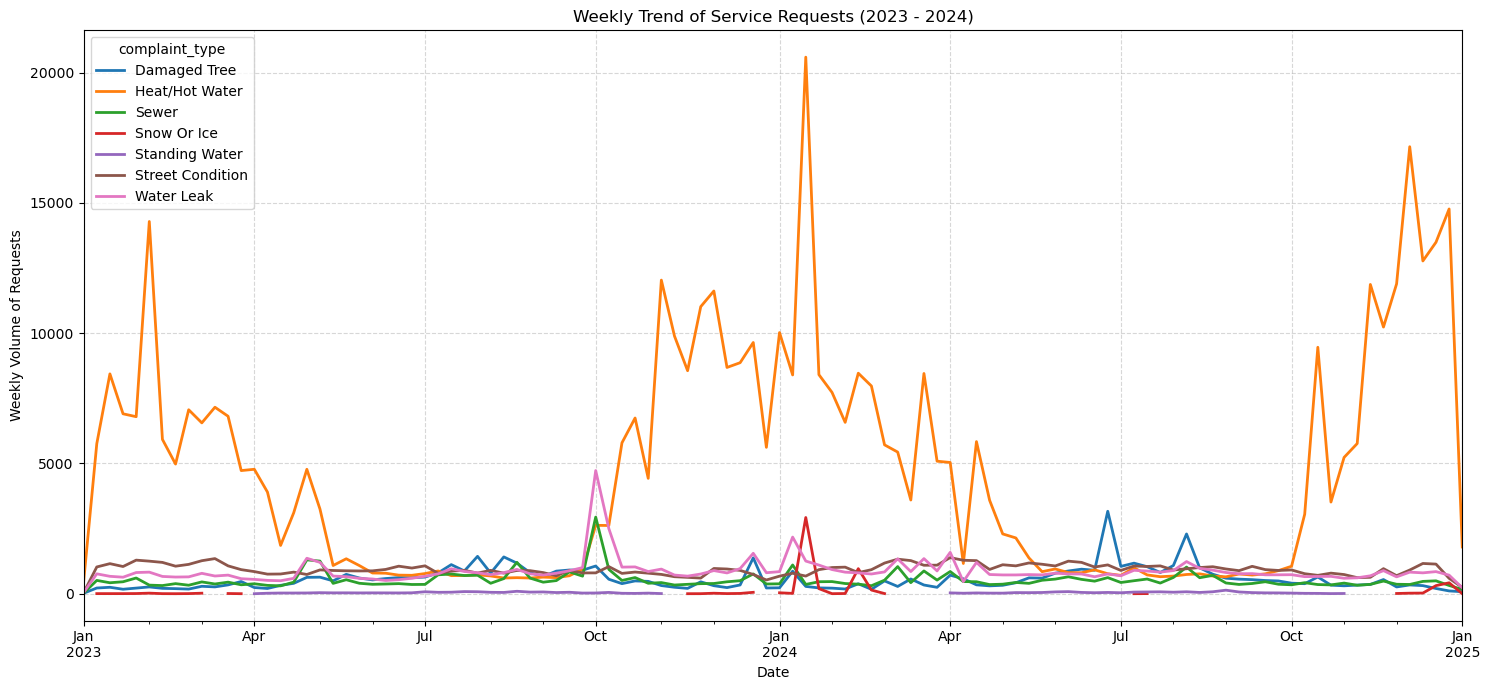

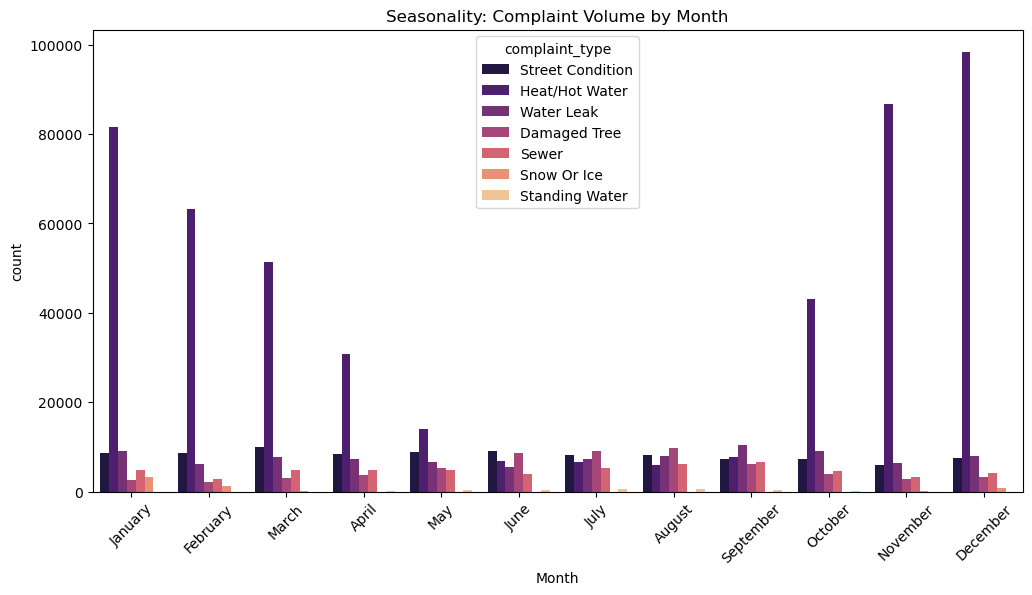

In [13]:
# --- Step 1: Filter Data for Targets ---
# We focus on the two high-value targets identified
targets = ['Snow Or Ice', 'Street Condition', 'Damaged Tree', 'Heat/Hot Water', 'Water Leak', 'Standing Water', 'Sewer']
df_analysis = df_311[df_311['complaint_type'].isin(targets)].copy()

# --- Step 2: Comparative Analysis by Borough ---
# We normalize by log scale if the disparity is huge, but raw counts are good for now.
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_analysis,
    x='borough',
    hue='complaint_type',
    palette='viridis'
)
plt.title('Comparison of Complaint Volume by Borough')
plt.ylabel('Number of Requests')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.legend(title='complaint_type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Step 3: Incident Type Over Time (Time Series) ---
# Resample by Week ('W') to smooth out daily noise but keep granular trends
# We pivot the data to get columns for each complaint_type
df_time = df_analysis.set_index('created_date')
df_resampled = df_time.groupby([pd.Grouper(freq='W'), 'complaint_type']).size().unstack()

# Plotting
plt.figure(figsize=(15, 7))
df_resampled.plot(ax=plt.gca(), linewidth=2)

plt.title('Weekly Trend of Service Requests (2023 - 2024)')
plt.ylabel('Weekly Volume of Requests')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='complaint_type')
plt.tight_layout()
plt.show()

# --- Step 4: Seasonality Check (Month of Year) ---
# This is critical for your "Weather" hypothesis.
# We expect Potholes to spike in Spring (March/April) due to freeze-thaw.
df_analysis['Month'] = df_analysis['created_date'].dt.month_name()
# Order for plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_analysis, 
    x='Month', 
    hue='complaint_type', 
    order=month_order,
    palette='magma'
)
plt.title('Seasonality: Complaint Volume by Month')
plt.xticks(rotation=45)
plt.show()